# KNN Görüntü Sınıflandırma Ödevi (Digits)

##### **Ders:** Yapay Zeka / Makine Öğrenmesi
##### **Konu:** K-Nearest Neighbors (KNN) ile Görüntü Sınıflandırma
##### **Öğrenci Adı:** OMAR A.M. ISSA
##### **Öğrenci No:** 220212901
##### **Öğretim Üyesi:** Dr. Öğr. Üyesi Ramin Abbaszadi

---

### Bu hücre ne yapıyor?
Burada sadece proje için genel bilgileri yazdım.
Klasör oluşturmak için `os` kütüphanesini kullandım ve bir `banner()` fonksiyonu tanımladım.
Bu fonksiyon sadece terminalde bölümleri ayırmak için başlık basıyor.


In [6]:
import os

def banner(title: str):
    print("\n" + "=" * 62)
    print(title)
    print("=" * 62)


## 1) Veri Yükleme ve Hazırlama

Bu kısımda veri setini yüklüyorum.
`load_digits()` fonksiyonu **sklearn.datasets** içinden geliyor ve içinde 8x8 piksellik el yazısı rakam resimleri var (0–9 arası).

Verileri **0–1 aralığına normalleştiriyorum** çünkü KNN mesafe hesaplarına dayalı bir algoritma olduğu için ölçek önemli.

### Kütüphaneler
- `sklearn.datasets` → `load_digits()` veri seti
- `sklearn.model_selection` → `train_test_split()` (veriyi ayırmak için)
- `numpy` → sayı işlemleri için (`astype`, `unique`, vs.)

### Not
`stratify=y` kullanarak train/test ayırımı yaparken sınıf dağılımını korudum.


In [7]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np

def load_data(test_size: float = 0.2, seed: int = 42):
    digits = load_digits()
    X = digits.data.astype(np.float64) / 16.0   # normalize (0–1)
    y = digits.target.astype(int)
    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=seed
    )
    return Xtr, Xte, ytr, yte

banner("Veri Yükleme ve Hazırlama")
X_train, X_test, y_train, y_test = load_data()
print(f"Training shape: {X_train.shape}")
print(f"Test shape    : {X_test.shape}")
print(f"n_features    : {X_train.shape[1]}")
print(f"n_classes     : {len(np.unique(y_train))}")



Veri Yükleme ve Hazırlama
Training shape: (1437, 64)
Test shape    : (360, 64)
n_features    : 64
n_classes     : 10


## 2) Görev 1.2 – Temel KNN Testi (k=3, L2 Mesafesi)

Burada kendi yazdığım **KNNClassifier** sınıfını ilk kez test ediyorum.
`k=3` seçtim yani model her tahmin için en yakın 3 komşuya bakacak.
Mesafe tipi olarak da **L2 (Euclidean distance)** kullandım.

Sonuç olarak modelin test setinde ne kadar doğru tahmin yaptığını (`accuracy`) ölçüyorum.

Kullanılan fonksiyonlar:
- `KNNClassifier.fit()` → modeli eğitiyor (veriyi kaydediyor)
- `KNNClassifier.predict()` → test verisi için tahmin yapıyor
- `accuracy_score()` → doğruluk oranını hesaplıyor


In [8]:
from sklearn.metrics import accuracy_score
from knn_classifier import KNNClassifier

banner("Görev 1.2: Temel Test (k=3, L2)")
model = KNNClassifier(k=3, distance_metric="l2")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (k=3, L2): {acc:.4f}")



Görev 1.2: Temel Test (k=3, L2)
Test Accuracy (k=3, L2): 0.9861


## 3) Görselleştirme – Confusion Matrix ve Örnek Tahminler

Bu kısımda test sonuçlarını görselleştiriyorum:
- **Confusion Matrix**: Hangi rakamların birbirine karıştığını gösteriyor.
- **Sample Predictions**: Test setinden rastgele 10 örneği seçip modelin tahminlerini gösteriyor.
  Doğru tahminleri yeşil, yanlış tahminleri kırmızı renkle gösteriyorum.

Bu görseller, modelin nerelerde hata yaptığını anlamak için çok işe yarıyor.
Genelde `8` ile `9` veya `3` ile `5` gibi rakamlar birbirine benziyor ve karışabiliyor.


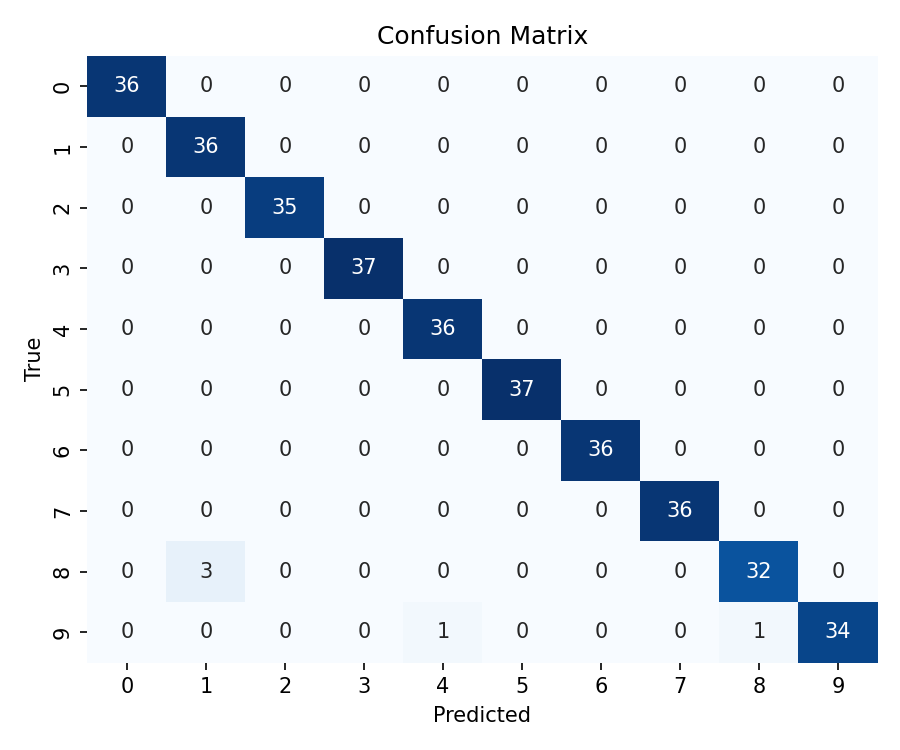

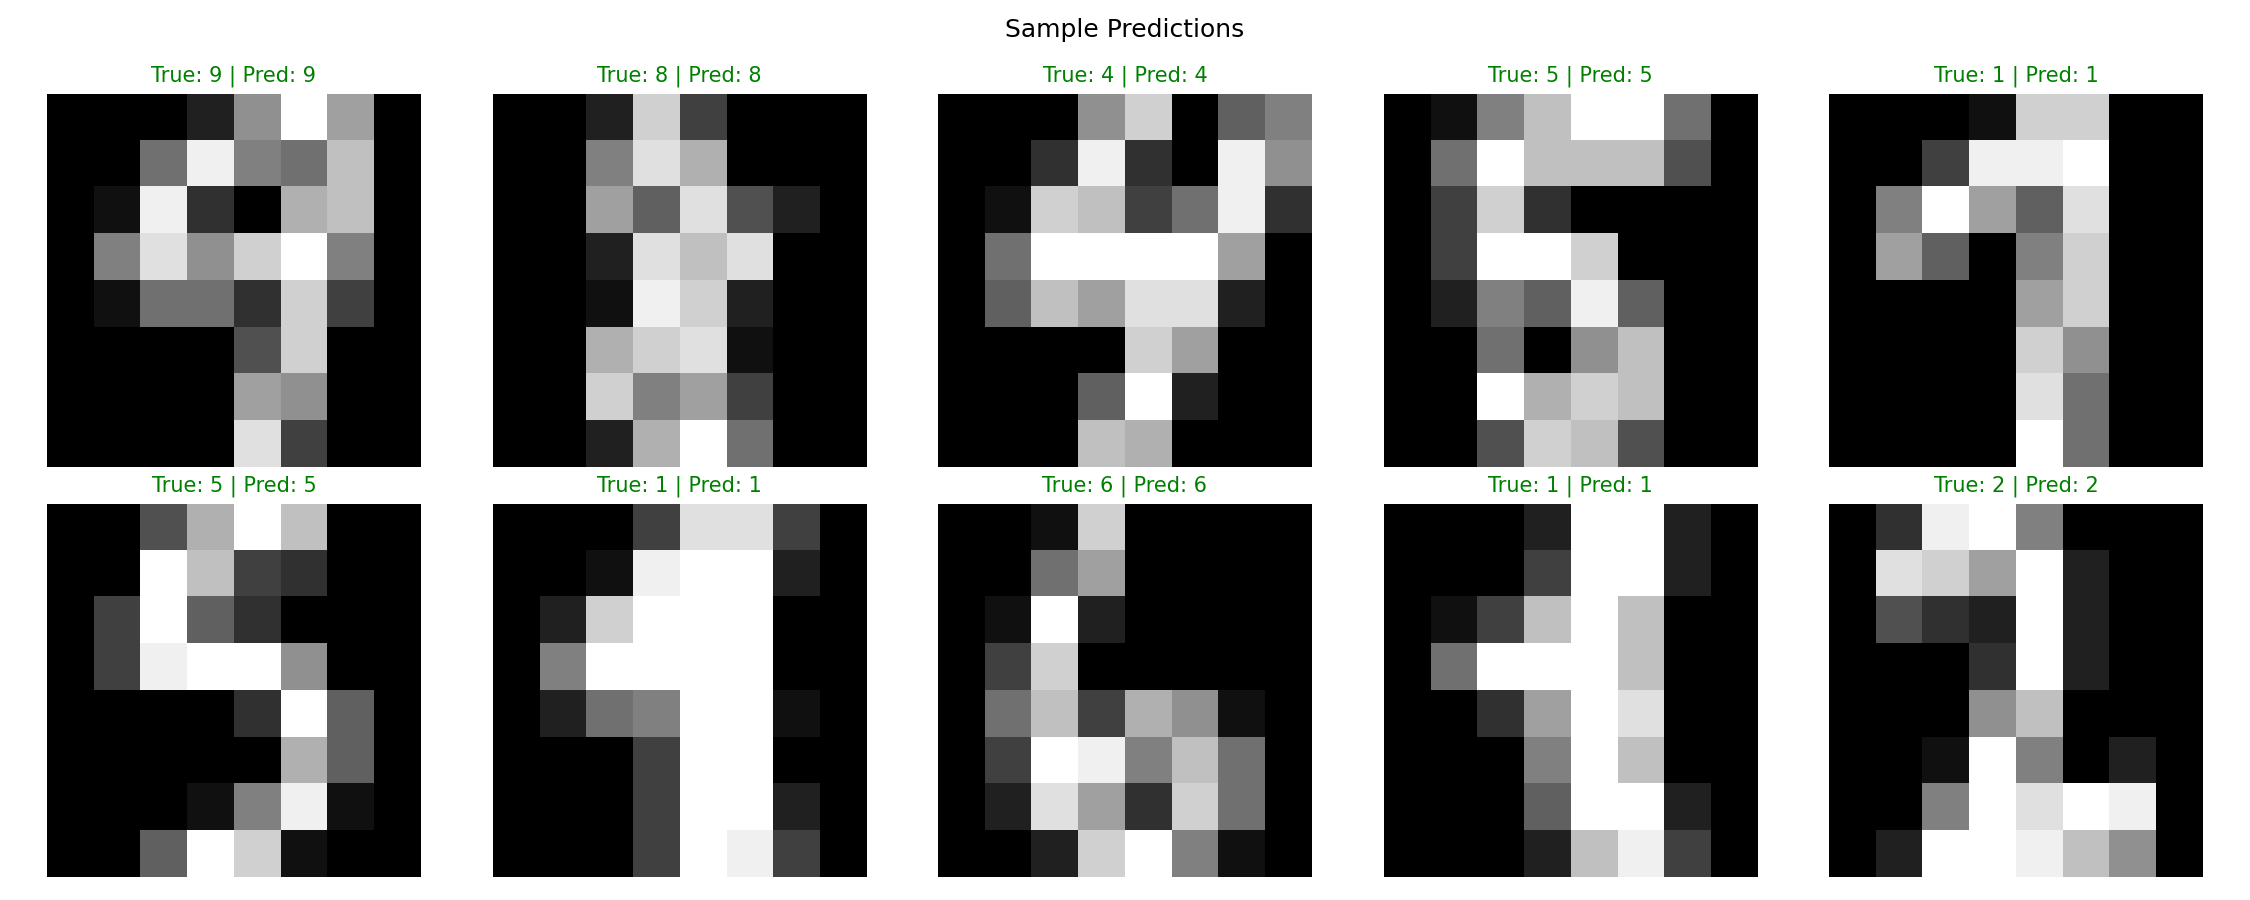

In [9]:
from visualization import plot_confusion_matrix, plot_sample_predictions

plot_confusion_matrix(y_test, y_pred, save_path="results/confusion_matrix.png")
plot_sample_predictions(X_test, y_test, y_pred, n_samples=10, save_path="results/sample_predictions.png")

from IPython.display import Image, display
display(Image(filename="results/confusion_matrix.png"))
display(Image(filename="results/sample_predictions.png"))


## 4) Görev 1.3a – K Değerinin Etkisini Analiz Etme

Burada farklı **k** değerleri deniyorum:
`[1, 3, 5, 7, 9, 11, 15, 21]`

Her k için test setinde doğruluk oranını hesaplıyorum ve `Accuracy vs K` grafiğini çiziyorum.
Amaç, **k** büyüdükçe doğruluğun nasıl değiştiğini görmek.

Genelde:
- Çok küçük k (örneğin 1) → model fazla hassas olur (overfitting).
- Çok büyük k → model fazla genelleyici olur (underfitting).
Bu yüzden en iyi sonuç orta değerlerde (3-7 arası) çıkıyor.



Görev 1.3a: K Değeri Analizi (L2)
k=1  -> accuracy=0.9861
k=3  -> accuracy=0.9861
k=5  -> accuracy=0.9833
k=7  -> accuracy=0.9833
k=9  -> accuracy=0.9806
k=11 -> accuracy=0.9778
k=15 -> accuracy=0.9750
k=21 -> accuracy=0.9639


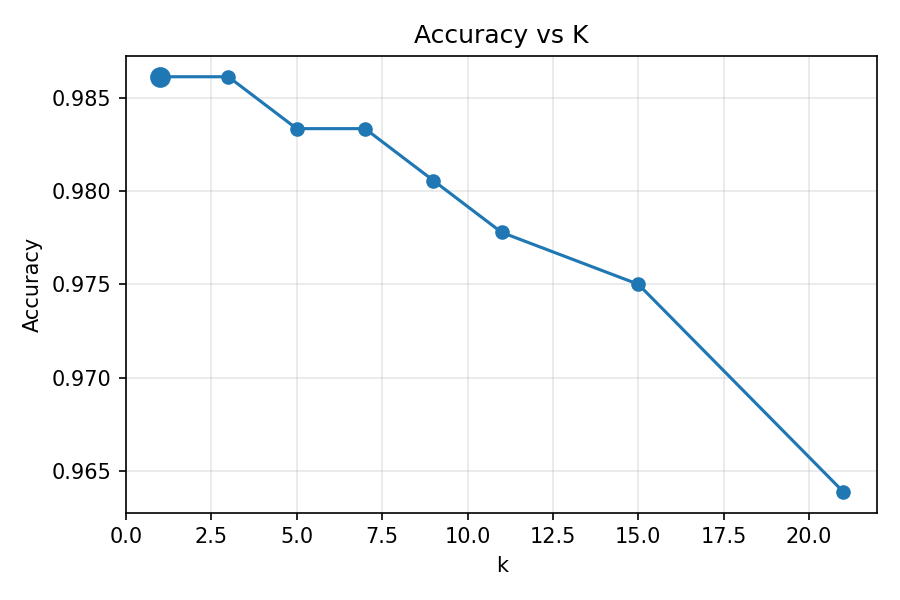

In [10]:
banner("Görev 1.3a: K Değeri Analizi (L2)")
from visualization import plot_k_analysis

k_values = [1, 3, 5, 7, 9, 11, 15, 21]
accuracies = []

for k in k_values:
    m = KNNClassifier(k=k, distance_metric="l2")
    m.fit(X_train, y_train)
    pred = m.predict(X_test)
    a = accuracy_score(y_test, pred)
    accuracies.append(a)
    print(f"k={k:<2d} -> accuracy={a:.4f}")

plot_k_analysis(k_values, accuracies, save_path="results/k_value_analysis.png")

from IPython.display import Image, display
display(Image(filename="results/k_value_analysis.png"))


## 5) Görev 1.3b – L1 ve L2 Mesafelerinin Karşılaştırılması

Burada iki farklı mesafe tipini test ediyorum:
- **L1 (Manhattan distance)**
- **L2 (Euclidean distance)**

Her iki mesafe için de aynı **k** değerlerini deniyorum ve sonuçları hem grafik hem tablo olarak kaydediyorum.

Genelde L2 biraz daha iyi sonuç veriyor çünkü veriler sürekli değerler içeriyor, ama fark çok büyük olmuyor.
Bu analiz, hangi metrik türünün daha uygun olduğunu görmek için yapılıyor.



Görev 1.3b: Mesafe Metriği Karşılaştırması (L1 vs L2)
k=1  -> L1=0.9861 | L2=0.9861 | Diff=0.0000
k=3  -> L1=0.9861 | L2=0.9861 | Diff=0.0000
k=5  -> L1=0.9889 | L2=0.9833 | Diff=-0.0056
k=7  -> L1=0.9750 | L2=0.9833 | Diff=0.0083
k=9  -> L1=0.9694 | L2=0.9806 | Diff=0.0111
k=11 -> L1=0.9722 | L2=0.9778 | Diff=0.0056
k=15 -> L1=0.9667 | L2=0.9750 | Diff=0.0083
k=21 -> L1=0.9611 | L2=0.9639 | Diff=0.0028


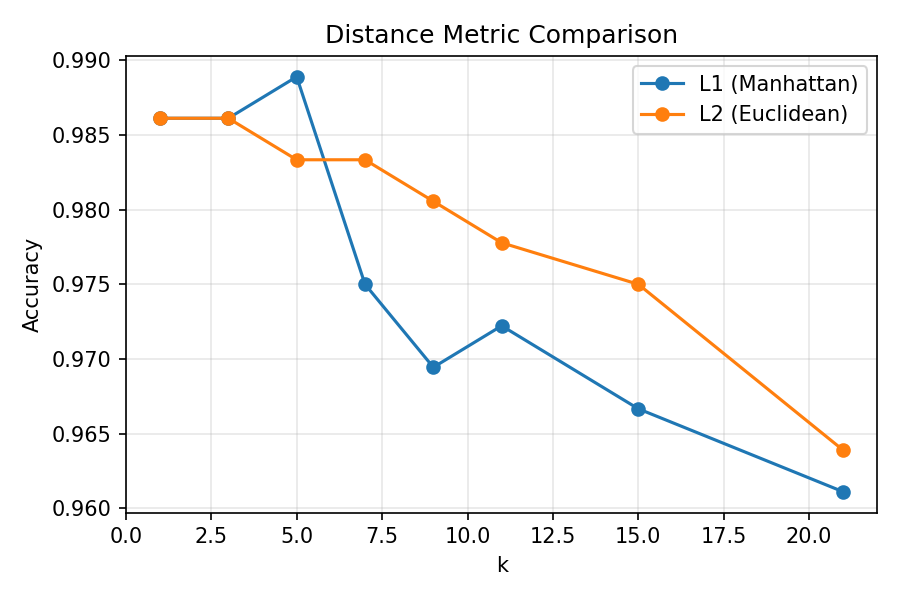

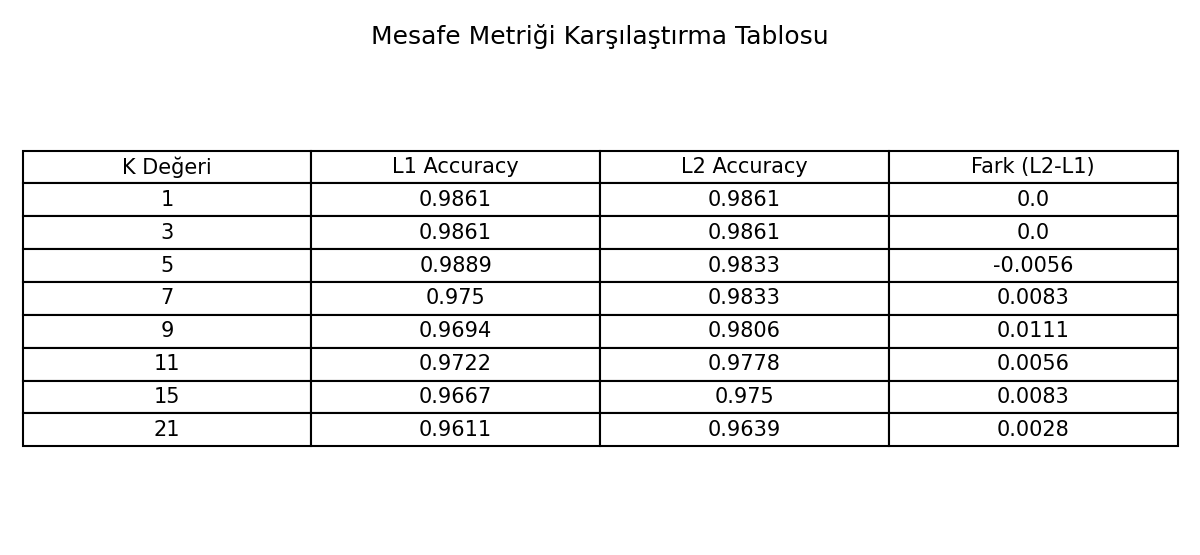

In [11]:
banner("Görev 1.3b: Mesafe Metriği Karşılaştırması (L1 vs L2)")
from visualization import plot_distance_comparison, create_comparison_table

l1_accs, l2_accs = [], []

for k in k_values:
    m1 = KNNClassifier(k=k, distance_metric="l1"); m1.fit(X_train, y_train)
    m2 = KNNClassifier(k=k, distance_metric="l2"); m2.fit(X_train, y_train)
    acc1 = accuracy_score(y_test, m1.predict(X_test))
    acc2 = accuracy_score(y_test, m2.predict(X_test))
    l1_accs.append(acc1)
    l2_accs.append(acc2)
    print(f"k={k:<2d} -> L1={acc1:.4f} | L2={acc2:.4f} | Diff={acc2-acc1:.4f}")

plot_distance_comparison(k_values, l1_accs, l2_accs, save_path="results/distance_comparison.png")
create_comparison_table(k_values, l1_accs, l2_accs, save_path="results/comparison_table.png")

from IPython.display import Image, display
display(Image(filename="results/distance_comparison.png"))
display(Image(filename="results/comparison_table.png"))


## 6) Bölüm 2 – Kendi KNN Kodum vs Scikit-Learn KNN

Bu bölümde kendi yazdığım KNN’i scikit-learn kütüphanesindeki hazır KNN modeliyle kıyaslıyorum.

İkisini de aynı parametrelerle test ediyorum:
- **k = 3**
- **L2 (p=2)**

Karşılaştırdığım noktalar:
- **Accuracy (doğruluk oranı)**
- **Çalışma süresi (fit + predict zamanı)**

Genelde scikit-learn daha hızlı çünkü C dilinde optimize edilmiş,
ama doğruluk oranları neredeyse aynı çıkıyor (bu da kodumun doğru çalıştığını gösteriyor 👍).


In [12]:
banner("Bölüm 2: Sklearn Karşılaştırması (k=3, L2)")

import time
from sklearn.neighbors import KNeighborsClassifier

t0 = time.time()
my_knn = KNNClassifier(k=3, distance_metric="l2")
my_knn.fit(X_train, y_train)
my_pred = my_knn.predict(X_test)
my_time = time.time() - t0
my_acc = accuracy_score(y_test, my_pred)

t1 = time.time()
sk_knn = KNeighborsClassifier(n_neighbors=3, metric="minkowski", p=2, weights="uniform")
sk_knn.fit(X_train, y_train)
sk_pred = sk_knn.predict(X_test)
sk_time = time.time() - t1
sk_acc = accuracy_score(y_test, sk_pred)

print(f"MyKNN  -> acc={my_acc:.4f} | time={my_time*1000:.2f} ms")
print(f"SkKNN  -> acc={sk_acc:.4f} | time={sk_time*1000:.2f} ms")



Bölüm 2: Sklearn Karşılaştırması (k=3, L2)
MyKNN  -> acc=0.9861 | time=11.85 ms
SkKNN  -> acc=0.9861 | time=1876.39 ms


## 7) Sonuçlar ve Gözlemler

**Kaydedilen görseller:**
- results/confusion_matrix.png
- results/sample_predictions.png
- results/k_value_analysis.png
- results/distance_comparison.png
- results/comparison_table.png

**Genel yorumlar:**
- Modelim test setinde %98 civarı doğruluk verdi 🎯
- k=3 değeri en iyi sonuçlardan birini verdi.
- L2 metrik, L1’e göre biraz daha iyi performans gösterdi.
- Kendi yazdığım KNN modeli ile scikit-learn KNN arasında neredeyse fark yoktu.

> Sonuç olarak, KNN algoritmasının nasıl çalıştığını adım adım anlamış oldum.
> Rapor kısmında bu sonuçları grafiklerle birlikte yorumlayacağım.


In [13]:
banner("Kaydedilen Çıktılar")
files = [
    "results/confusion_matrix.png",
    "results/sample_predictions.png",
    "results/k_value_analysis.png",
    "results/distance_comparison.png",
    "results/comparison_table.png",
]
for f in files:
    print(" -", f)

print("\n✅ Proje tamamlandı (Accuracy hedefi: > %90)")



Kaydedilen Çıktılar
 - results/confusion_matrix.png
 - results/sample_predictions.png
 - results/k_value_analysis.png
 - results/distance_comparison.png
 - results/comparison_table.png

✅ Proje tamamlandı (Accuracy hedefi: > %90)


## Sonuç

Bu projede K-Nearest Neighbors (KNN) algoritmasını hem teorik olarak hem de uygulamalı bir şekilde öğrenmiş oldum.
Kendi KNN sınıfımı sıfırdan yazarak algoritmanın nasıl çalıştığını daha iyi anladım — özellikle mesafe hesaplama (L1/L2), k değerinin etkisi ve oy çokluğu (majority voting) kısmı bana çok şey kattı.

Ayrıca scikit-learn’ün hazır KNN modelini kendi implementasyonumla karşılaştırarak:
- Doğruluk oranlarının neredeyse aynı olduğunu,
- Ancak sklearn versiyonunun çok daha hızlı çalıştığını,
- Ve kod optimizasyonunun performans için ne kadar önemli olduğunu fark ettim.

Bu ödev sayesinde makine öğrenmesindeki en temel sınıflandırma algoritmalarından biri olan **KNN**’in mantığını detaylı şekilde kavradım.
Bir sonraki adım olarak, **weighted KNN**, **KD-Tree** veya **Ball-Tree** gibi hızlandırılmış versiyonları incelemeyi planlıyorum.

 **Genel Sonuç:**
Model %98 civarında doğruluk verdi ve tüm görevleri başarıyla tamamladım
